### Importing everything I will be using

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif

import spacy
import nltk
from nltk.stem.porter import *
from  nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import re


### Problem Statement 

For this particular project we are provided with the following problem statement:
_What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?_

On top of this predetermined problem statement, I will measure success by choosing the best classification model that will predict classes consistently over the class majority baseline, based on classification metrics such as cross val score, confidence intervals, and confusion matrix metrics. 

#### Reading in our data from the scraping notebook

In [2]:
df = pd.read_csv('../Data/reddit_data.csv')

In [3]:
df.head()

,titles,subreddits,num_comments,upvotes,age_post
0,[Highlight] Jimmy Butler misses the crucial go...,nba,1874,7781,0 days 01:40:44
1,r/mildlyinfuriating predictions tournament 1,mildlyinfuriating,600,208868,0 days 13:39:20
2,Mads Mikkelsen probably should’ve been used be...,marvelstudios,212,16677,0 days 04:24:02
3,"Gee, if only there were warning signs…",WhitePeopleTwitter,1052,49847,0 days 05:52:22
4,Average Republican,PoliticalHumor,368,14442,0 days 05:36:43


In [4]:
df.shape

(31488, 5)

#### Dropping duplicate columns based on title (since on reddit the post title cannot be changed once published)

In [5]:
df['titles'].nunique()

24993

In [6]:
df.drop_duplicates(subset='titles', keep='last', inplace=True)

In [7]:
df.reset_index(inplace=True, drop=True)

In [8]:
df.head()

,titles,subreddits,num_comments,upvotes,age_post
0,[Highlight] Jimmy Butler misses the crucial go...,nba,1874,7781,0 days 01:40:44
1,Mads Mikkelsen probably should’ve been used be...,marvelstudios,212,16677,0 days 04:24:02
2,"Gee, if only there were warning signs…",WhitePeopleTwitter,1052,49847,0 days 05:52:22
3,Average Republican,PoliticalHumor,368,14442,0 days 05:36:43
4,Due to inflation the price is now $0.69,comics,246,13443,0 days 05:20:41


#### At this step I am doing some feature engineering

In [9]:
# Adding a column based on count of words in "Title"

df['title_word_count'] = [len(x.split(' ')) for x in df['titles']]

In [10]:
# I have saved my "age_post" as a timedelta object, so I need to convert it back to seconds

time_sec = []

for time in df['age_post']:
    lst = []
    
    # splitting the delta string 
    split_time = re.split('days|:|\*|\n', time)
    
    # taking the split strings and int casting them
    for sub in split_time:
        lst.append(int(sub))
     
    # multiplying and summing the days, hours, mins and secs to seconds
    time_sec.append(lst[0]*86400+lst[1]*3600+lst[2]*60+lst[3])

In [11]:
# adding converted age of post in seconds, to the dataframe
df['age_post_sec'] = time_sec

In [124]:
# I am standard scaling just the "upvotes" and the "age_post_sec" in order to be used in the models

ss = StandardScaler()
ups_ss = ss.fit_transform(df['upvotes'].values.reshape(-1, 1))

In [125]:
df['time_sec_ss'] = ss.fit_transform(df['age_post_sec'].values.reshape(-1, 1))

In [126]:
df['ups_ss'] = ups_ss

#### Doing some basic cleaning on dataset by checking for nulls, looking at descriptive statistics

In [15]:
df.isnull().sum()

titles              0
subreddits          0
num_comments        0
upvotes             0
age_post            0
title_word_count    0
age_post_sec        0
time_sec_ss         0
ups_ss              0
dtype: int64

In [16]:
df.describe()

,num_comments,upvotes,title_word_count,age_post_sec,time_sec_ss,ups_ss
count,24993.000000,24993.000000,24993.000000,24993.000000,2.499300e+04,2.499300e+04
mean,98.872564,2251.953947,9.276317,33740.130717,9.419993e-17,-5.365434e-17
std,388.824545,6432.912676,8.517094,17313.599878,1.000020e+00,1.000020e+00
min,0.000000,63.000000,1.000000,778.000000,-1.903867e+00,-3.402810e-01
25%,12.000000,307.000000,4.000000,20384.000000,-7.714397e-01,-3.023503e-01
50%,30.000000,663.000000,7.000000,31412.000000,-1.344710e-01,-2.470088e-01
75%,80.000000,1702.000000,12.000000,44840.000000,6.411198e-01,-8.549237e-02
max,26180.000000,241124.000000,63.000000,86586.000000,3.052336e+00,3.713354e+01


#### Above I am looking for any extremes based on the mean and median. Immediately I see the Max values of 'num_comments' and 'upvotes'. The min number of 0 for 'num_comments' is also concerning. I will look into this later. 

In [17]:
df.head()

,titles,subreddits,num_comments,upvotes,age_post,title_word_count,age_post_sec,time_sec_ss,ups_ss
0,[Highlight] Jimmy Butler misses the crucial go...,nba,1874,7781,0 days 01:40:44,12,6044,-1.599707,0.859511
1,Mads Mikkelsen probably should’ve been used be...,marvelstudios,212,16677,0 days 04:24:02,18,15842,-1.033782,2.242427
2,"Gee, if only there were warning signs…",WhitePeopleTwitter,1052,49847,0 days 05:52:22,7,21142,-0.727658,7.398825
3,Average Republican,PoliticalHumor,368,14442,0 days 05:36:43,2,20203,-0.781894,1.894988
4,Due to inflation the price is now $0.69,comics,246,13443,0 days 05:20:41,8,19241,-0.837458,1.739689


### Below I am taking the titles, cleaning and lemmatizing them, before being put through the TF-IDF

In [18]:
lem = WordNetLemmatizer()

In [19]:
words_df = []

In [20]:
for row in df['titles']:
    filter_sent = []
    
    # taking the title sentence and stripping extra characters
    sent = row
    sent = re.sub(r'[^\w\s]', '', sent) 
    
    # tokenizing/splitting the sentence to individual words
    words = nltk.word_tokenize(sent) 
    
    # applying WordNetLemmatizer to the individual words
    for word in words:
        filter_sent.append(lem.lemmatize(word))
        
    # appending individual lemmatized words to list    
    words_df.append(filter_sent)

In [21]:
# combining individual words in list to form complete title again

lem_words = [' '.join(x) for x in words_df]

In [22]:
# putting lemmatized word title list through TF-IDF with 500 max features

tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 500,
#                        max_df = .0001,
#                        min_df = .0008,
                       norm = 'l2')

tvec.fit(lem_words)

TfidfVectorizer(max_features=500, stop_words='english', strip_accents='ascii')

In [23]:
df_tvec = pd.DataFrame(tvec.transform(lem_words).todense(),
                  columns = tvec.get_feature_names())

#### I am not cleaning or lemmatizing the subreddit names since it is controlled by reddit, so I will just send it through the TF-IDF

In [24]:
tvec_2 = TfidfVectorizer(strip_accents = 'ascii',
                         max_features = 500,
                         norm = 'l2')
tvec_2.fit(df['subreddits'])

TfidfVectorizer(max_features=500, strip_accents='ascii')

In [25]:
df_tvec2 = pd.DataFrame(tvec_2.transform(df['subreddits']).todense(),
                  columns = tvec_2.get_feature_names())

In [26]:
df_tvec2 = df_tvec2.add_prefix('sub_')

In [27]:
# df_tvec.drop('target', inplace=True, axis=1)

In [28]:
# df_tvec.drop('upvotes', inplace=True, axis=1)

In [29]:
df_tvec.shape

(24993, 500)

#### I create my target column for use in modeling based on the MEDIAN number of comments for my entire dataset

In [30]:
df['target_y'] = [1 if x >= (np.median(df['num_comments'])) else 0 for x in df['num_comments']]

#### Here I made 2 different dataframes, one which include the subreddits and one which does not for separate testing

In [31]:
working_df = pd.concat([df, df_tvec], axis=1)

In [32]:
df_subs = pd.concat([df, df_tvec, df_tvec2], axis=1)

In [37]:
df_subs.shape

(24993, 1010)

In [38]:
working_df.shape

(24993, 510)

### Some plotting for visually checking outliers

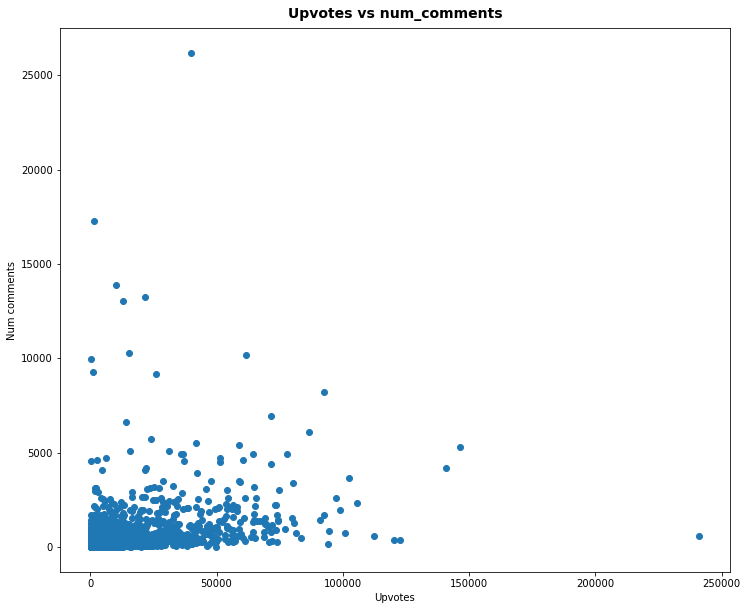

In [39]:
X_plot = working_df['upvotes']
y_plot = working_df['num_comments']

plt.figure(figsize=(12,10))
plt.title('Upvotes vs num_comments',
            fontdict=dict(fontsize=14,
            fontweight='bold',
            color='black'),
            pad=10)
plt.scatter(X_plot, y_plot)
plt.xlabel("Upvotes")
plt.ylabel("Num comments")
plt.show()

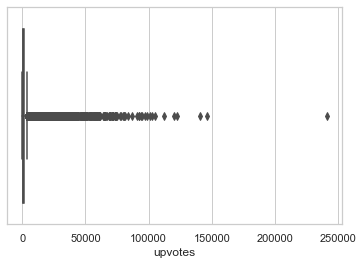

In [40]:
# sns.set(font_scale=1.4)
sns.set_theme(style="whitegrid")
sns.boxplot(x=working_df["upvotes"]);

<AxesSubplot:xlabel='num_comments'>

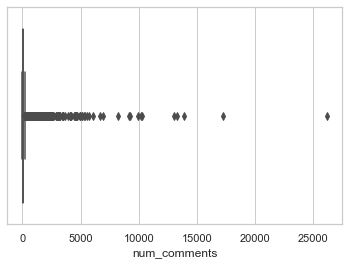

In [41]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=working_df["num_comments"])

#### After looking at the scatterplot and BoxPlots above we can see some extreme outliers
- After seeing the extreme outliers, I wanted to pull a few examples of each for inspection below 

In [42]:
working_df.sort_values(by='upvotes', ascending=False)[:2]

,titles,subreddits,num_comments,upvotes,age_post,title_word_count,age_post_sec,time_sec_ss,ups_ss,target_y,...,world,worth,wrong,yall,yeah,year,yes,yesterday,young,youre
11602,r/mildlyinfuriating predictions tournament 1,mildlyinfuriating,600,241124,0 days 18:29:10,5,66550,1.895072,37.133541,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23826,[OC] A pic I took of my husband with all the b...,pics,5280,146415,0 days 23:29:02,14,84542,2.934276,22.410677,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### I am checking the normalized value count of my target column to find my baseline / class majority, which is 50.52%

In [43]:
working_df['target_y'].value_counts(normalize=True)

1    0.505261
0    0.494739
Name: target_y, dtype: float64

#### I was doing some testing for removing emojis from titles, but I found 95% of them dont have emojis, So I opted against it.

In [44]:
# import spacy
# from spacymoji import Emoji

# nlp = spacy.load("en_core_web_sm")
# nlp.add_pipe("emoji", first=True)
# # doc = nlp("This is a test 😻 👍🏿")

# pd.DataFrame([(len(nlp(x)._.emoji)) for x in working_df['titles']]).value_counts()

### This is the function I will test models on; based on cross_val_score, using StratifiedKFolds, and the Confidence interval

In [45]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=620,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, s.mean(), 2 * s.std()))

### Testing Random Forest with various different parameters

In [46]:
# I ran this model multiple times with different parameters each time
# What is here now is my best result

rf = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 300,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.02,
#                             oob_score=True,
                            min_samples_split=.1,
                            max_depth = 150,
                            random_state=620)



#### Setting my X and y value, then splitting into my test/train
- For the first round of model testing I used just my DF that includes only my lemmatized and vectorized titles. I will add the subreddit features in another test below

In [47]:
X = working_df.drop(['num_comments', 'titles', 'subreddits', 'target_y', 'age_post', 'upvotes'], axis=1)
y = working_df['target_y']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 620)

#### Fitting and scoring my model on X_train/test, then on X, y itself

In [49]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=150, min_samples_split=0.1, n_estimators=300,
                       n_jobs=-1, random_state=620)

In [50]:
rf.score(X_train, y_train)

0.7347704311293388

In [51]:
rf.score(X_test, y_test)

0.7205441088217643

In [52]:
score(rf, 'Random Forest', X_train, y_train)

Random Forest Score: 0.72 +- 0.021


In [53]:
score(rf, 'Random Forest', X_test, y_test)

Random Forest Score: 0.72 +- 0.039


In [54]:
score(rf, 'Random Forest', X, y)

Random Forest Score: 0.72 +- 0.021


#### I am extracting the feature importances from the Random Forest model and combining with the feature name

In [55]:
rf.feature_importances_

array([8.15891043e-02, 1.66067350e-01, 1.73233389e-01, 4.22936158e-01,
       1.01712367e-04, 3.81103867e-04, 7.07378967e-05, 7.49420049e-05,
       8.33624007e-05, 8.33739943e-04, 2.62908084e-04, 1.10122319e-04,
       5.77603473e-05, 2.34259895e-04, 1.09565318e-04, 2.77425568e-05,
       2.65111126e-04, 4.38013187e-05, 4.12207072e-04, 1.03303712e-04,
       8.08244839e-05, 4.07019370e-04, 1.17555197e-04, 4.21148870e-05,
       2.92837290e-04, 5.03229700e-03, 2.41338458e-04, 8.85513866e-05,
       2.01467601e-04, 2.87337724e-04, 2.65613462e-04, 4.49063912e-04,
       1.80266353e-04, 3.52826140e-05, 8.09416057e-04, 1.04987429e-04,
       2.82639241e-05, 1.89281436e-04, 1.60028708e-04, 7.05842180e-04,
       2.55343962e-05, 1.83472169e-04, 2.75068109e-04, 1.57296464e-03,
       1.51123714e-04, 3.45603004e-04, 3.85118348e-05, 1.47673377e-04,
       8.49290555e-05, 1.14729806e-04, 1.42231059e-04, 6.33467111e-05,
       2.04077896e-03, 1.05705049e-04, 9.02010365e-05, 1.41072777e-04,
      

In [56]:
feature_importance = pd.DataFrame({'Variable':X.columns,
                                  'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)


In [57]:
feature_importance.head()

,Variable,Importance
3,ups_ss,0.422936
2,time_sec_ss,0.173233
1,age_post_sec,0.166067
0,title_word_count,0.081589
152,game,0.006652


#### Here I tested whether or not dropping outlier comments would give model better scores. It didnt change much

In [58]:
working_df_out = working_df.drop(working_df[(working_df['num_comments'] > 500)| (working_df['num_comments'] == 0)].index)

In [59]:
working_df_out['num_comments'].describe()

count    24099.000000
mean        61.048508
std         81.918986
min          1.000000
25%         12.000000
50%         29.000000
75%         73.000000
max        500.000000
Name: num_comments, dtype: float64

In [60]:
X = working_df_out.drop(['num_comments', 'titles', 'subreddits', 'target_y', 'age_post'], axis=1)
y = working_df_out['target_y']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 620)

In [62]:
score(rf, 'Random Forest', X_train, y_train)

Random Forest Score: 0.71 +- 0.013


In [63]:
working_df_out['target_y'].value_counts(normalize=True)

0    0.506411
1    0.493589
Name: target_y, dtype: float64

In [64]:
working_df_out.shape

(24099, 510)

### Testing Extra Trees classifier using multiple parameters, best ones were similar to Random Forest, but random forest still had better scores

In [65]:
et = ExtraTreesClassifier(n_jobs=-1,
                          n_estimators = 300,
                          min_samples_split=.1,
                          max_depth = 150,
                          random_state=620)

In [66]:
et.fit(X,y)

ExtraTreesClassifier(max_depth=150, min_samples_split=0.1, n_estimators=300,
                     n_jobs=-1, random_state=620)

In [67]:
score(et, 'Extra Trees', X, y)

Extra Trees Score: 0.71 +- 0.019


### Using Bagging Classifier didnt produce better scores than random Forest

In [68]:
dt = DecisionTreeClassifier(random_state=620)
bdt = BaggingClassifier(dt, n_jobs=-1, n_estimators = 200, random_state=620)


In [69]:
bdt.fit(X,y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=620),
                  n_estimators=200, n_jobs=-1, random_state=620)

In [70]:
score(bdt, 'BaggingClassifier', X, y)

BaggingClassifier Score: 0.70 +- 0.016


### I have also tested K Nearest Neighbors and didnt improve any score and showed heavy overfitting

In [71]:
knn = KNeighborsClassifier(n_neighbors=10,
                           metric='manhattan',
                           weights='distance')


knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [72]:
knn.score(X_train, y_train)

1.0

In [73]:
knn.score(X_test, y_test)

0.6599585062240664

In [74]:
score(knn, 'KNN', X, y)

KNN Score: 0.67 +- 0.016


### Now that I have done some testing with various models I choose to use Random Forest and tweak things to see if I can improve my model
- I will now use the dataframe that includes the TFIDF vectorized subreddits for further testing

In [75]:
# Dropping rows with greater than 30k upvotes
df_subs_2 = df_subs.drop(df_subs[df_subs['upvotes'] > 30000].index)

In [76]:
# Dropping rows with comments over 1000 and comments = to 0
df_subs_2 = df_subs_2.drop(df_subs_2[(df_subs_2['num_comments'] > 1000)| (working_df['num_comments'] == 0)].index)

/var/folders/1f/5j58gsq935x96pkddycgky2r0000gn/T/ipykernel_16984/4253381836.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_subs_2 = df_subs_2.drop(df_subs_2[(df_subs_2['num_comments'] > 1000)| (working_df['num_comments'] == 0)].index)


In [77]:
# resetting the target value after dropping some num_comments rows
df_subs_2['target_y'] = [1 if x >= (np.median(df_subs_2['num_comments'])) else 0 for x in df_subs_2['num_comments']]

In [78]:
df_subs_2.shape

(24394, 1010)

In [79]:
# resetting index
df_subs_2.reset_index(inplace=True, drop=True)

In [80]:
df_subs_2.head()

,titles,subreddits,num_comments,upvotes,age_post,title_word_count,age_post_sec,time_sec_ss,ups_ss,target_y,...,sub_worldnews,sub_wow,sub_wtf,sub_xenoblade_chronicles,sub_xqcow,sub_yakuzagames,sub_yesyesyesyesno,sub_youngpeopleyoutube,sub_yurop,sub_zelda
0,Mads Mikkelsen probably should’ve been used be...,marvelstudios,212,16677,0 days 04:24:02,18,15842,-1.033782,2.242427,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Average Republican,PoliticalHumor,368,14442,0 days 05:36:43,2,20203,-0.781894,1.894988,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Due to inflation the price is now $0.69,comics,246,13443,0 days 05:20:41,8,19241,-0.837458,1.739689,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Wendy's Tendies,wallstreetbets,554,19340,0 days 06:04:24,2,21864,-0.685956,2.656400,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,“Thoughts and prayers”…..,facepalm,466,8856,0 days 04:03:30,3,14610,-1.104941,1.026623,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Testing the new DF with subreddits, I ran it through RandomForest again and my model improved

In [81]:
rf2 = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 400,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.02,
#                             oob_score=True,
                            min_samples_split=.1,
                            max_depth = 150,
                            random_state=620)



In [82]:
X_2 = df_subs_2.drop(['num_comments', 'titles', 'subreddits', 'target_y', 'age_post', 'upvotes','age_post_sec'], axis=1)
y_2 = df_subs_2['target_y']

In [83]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,
                                                            y_2,
                                                            test_size = 0.20,
                                                            random_state = 620)

In [84]:
rf2.fit(X_train_2, y_train_2)

RandomForestClassifier(max_depth=150, min_samples_split=0.1, n_estimators=400,
                       n_jobs=-1, random_state=620)

In [85]:
rf2.score(X_train_2, y_train_2)

0.7449141685882654

In [86]:
rf2.score(X_test_2, y_test_2)

0.7290428366468539

In [87]:
score(rf2, 'Random Forest', X_train_2, y_train_2)

Random Forest Score: 0.73 +- 0.019


In [88]:
score(rf2, 'Random Forest', X_test_2, y_test_2)

Random Forest Score: 0.72 +- 0.029


In [89]:
score(rf2, 'Random Forest 2', X_2, y_2)

Random Forest 2 Score: 0.73 +- 0.014


### Getting the feature importances from RandomForest model

In [90]:
feat_imp_subs = pd.DataFrame({'Variable':X_2.columns,
                                  'Importance':rf2.feature_importances_}).sort_values('Importance', ascending=False)


In [91]:
feat_imp_subs.reset_index(inplace=True, drop=True)
feat_imp_subs[:10]

,Variable,Importance
0,ups_ss,0.443952
1,time_sec_ss,0.212473
2,title_word_count,0.087592
3,game,0.006317
4,sub_squaredcircle,0.005751
5,people,0.005554
6,art,0.005345
7,sub_politicalcompassmemes,0.004816
8,sub_politics,0.004369
9,sub_publicfreakout,0.003917


### Plotting some points from our df_subs_2 dataframe

In [92]:
df_subs_2.head(1)

,titles,subreddits,num_comments,upvotes,age_post,title_word_count,age_post_sec,time_sec_ss,ups_ss,target_y,...,sub_worldnews,sub_wow,sub_wtf,sub_xenoblade_chronicles,sub_xqcow,sub_yakuzagames,sub_yesyesyesyesno,sub_youngpeopleyoutube,sub_yurop,sub_zelda
0,Mads Mikkelsen probably should’ve been used be...,marvelstudios,212,16677,0 days 04:24:02,18,15842,-1.033782,2.242427,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### I wanted to see the relation of upvotes to number of comments since that seems to be the main importance feature in the model

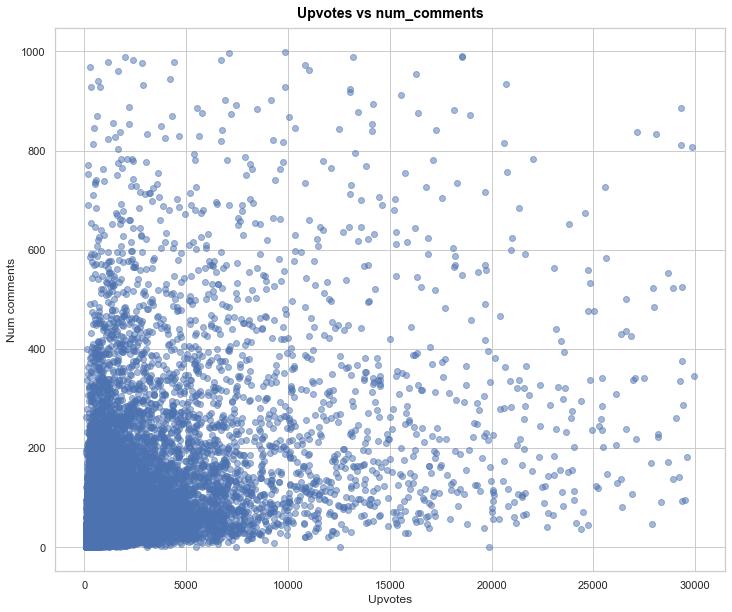

In [93]:
X_plot = df_subs_2['upvotes']
y_plot = df_subs_2['num_comments']

plt.figure(figsize=(12,10))
plt.title('Upvotes vs num_comments',
            fontdict=dict(fontsize=14,
            fontweight='bold',
            color='black'),
            pad=10)
plt.scatter(X_plot, y_plot,
            alpha = 0.5)
plt.xlabel("Upvotes")
plt.ylabel("Num comments")
plt.show()

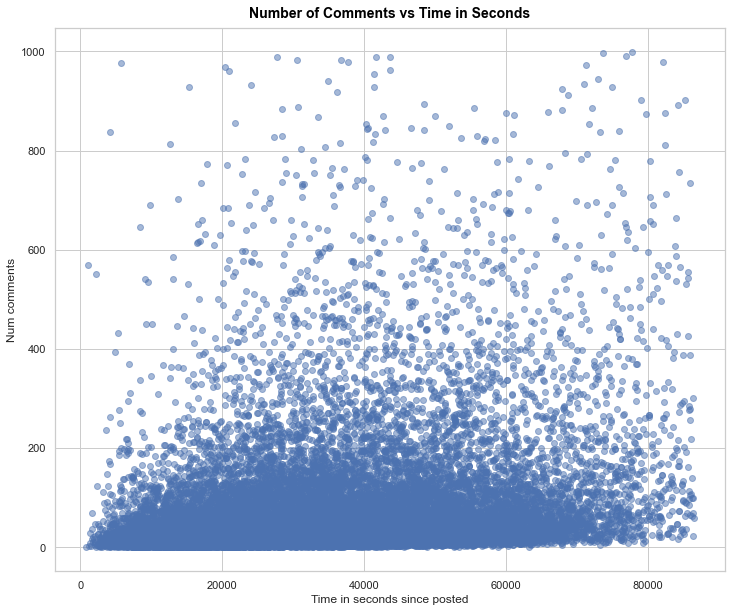

In [94]:
X_plot = df_subs_2['age_post_sec']
y_plot = df_subs_2['num_comments']

plt.figure(figsize=(12,10))
plt.title('Number of Comments vs Time in Seconds',
            fontdict=dict(fontsize=14,
            fontweight='bold',
            color='black'),
            pad=10)
plt.scatter(X_plot, y_plot,
            alpha=0.5)
plt.xlabel("Time in seconds since posted")
plt.ylabel("Num comments")
plt.show()

### The upvotes distribution and num_comments distribution is still heavily rightskewed even after dropping some outliers

''

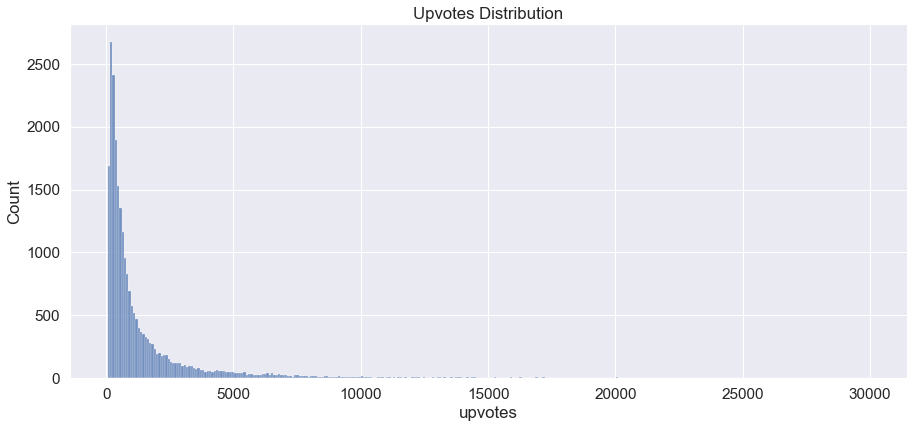

In [95]:

sns.set(font_scale=1.4)
sns.displot(df_subs_2, x="upvotes", height=6, aspect= 13/6).set(title='Upvotes Distribution')
;

''

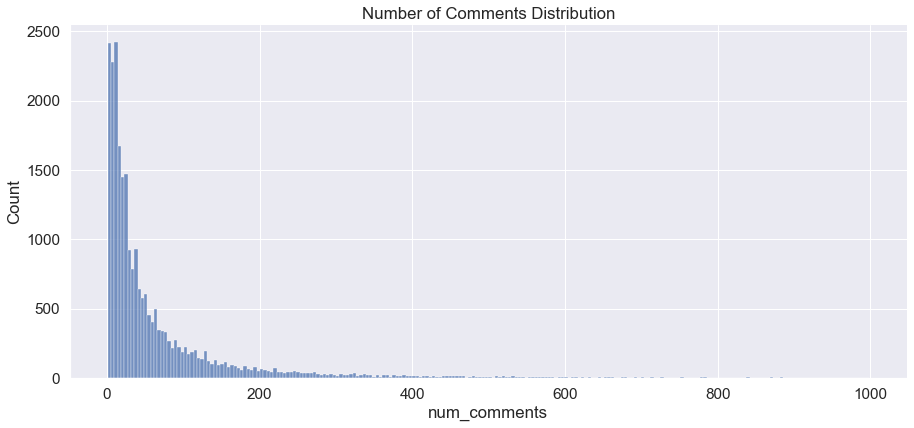

In [96]:
sns.displot(df_subs_2, x="num_comments", height=6, aspect= 13/6).set(title='Number of Comments Distribution')
;

### The age_post_sec feature is the most normalized overall

''

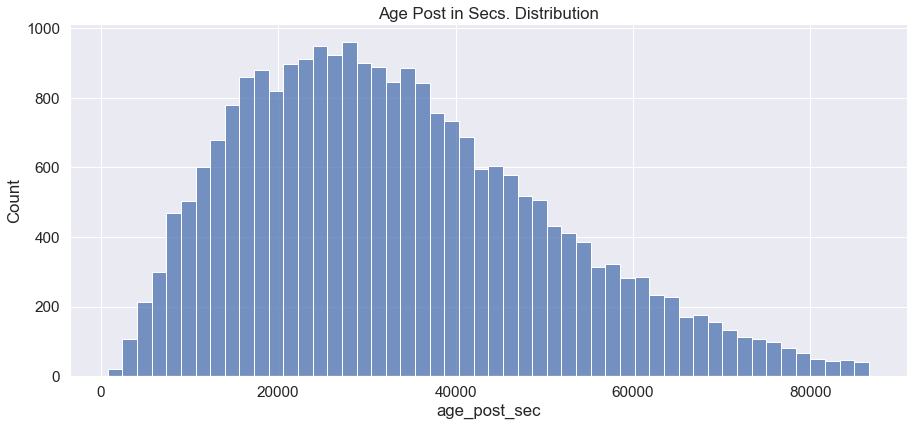

In [97]:
sns.displot(df_subs_2, x="age_post_sec", height=6, aspect= 13/6).set(title='Age Post in Secs. Distribution')
;

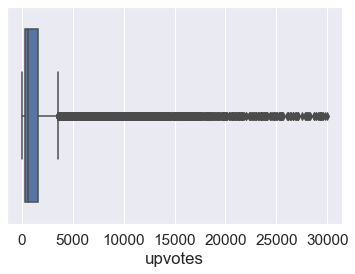

In [98]:
sns.boxplot(x=df_subs_2["upvotes"]);

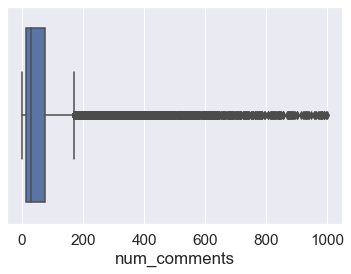

In [99]:
sns.boxplot(x=df_subs_2["num_comments"]);

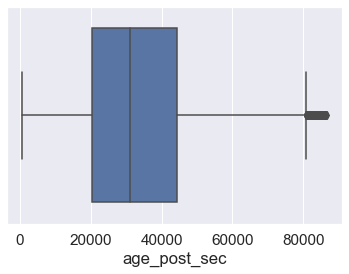

In [100]:
sns.boxplot(x=df_subs_2["age_post_sec"]);

### I attempted to drop some major outliers and test in the model while everything else stays the same

In [101]:
df_subs_3 = df_subs.drop(df_subs[df_subs['upvotes'] > 2500].index)
df_subs_3 = df_subs_3.drop(df_subs_3[df_subs_3['num_comments'] > 140].index)


In [102]:
df_subs_2.shape

(24394, 1010)

In [103]:
df_subs_3.shape

(18969, 1010)

''

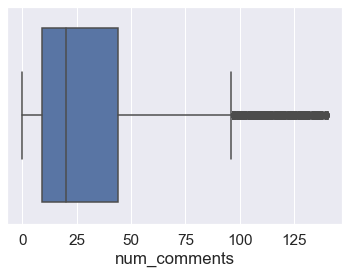

In [104]:
sns.boxplot(x=df_subs_3["num_comments"])
;

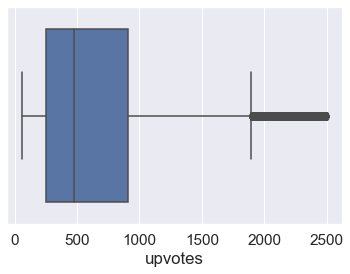

In [105]:
# fig.set_size_inches(11.7, 8.27)
sns.boxplot(x=df_subs_3["upvotes"]);

### We can see a much better distribution for num_comments and upvotes (albeit still skewed)

''

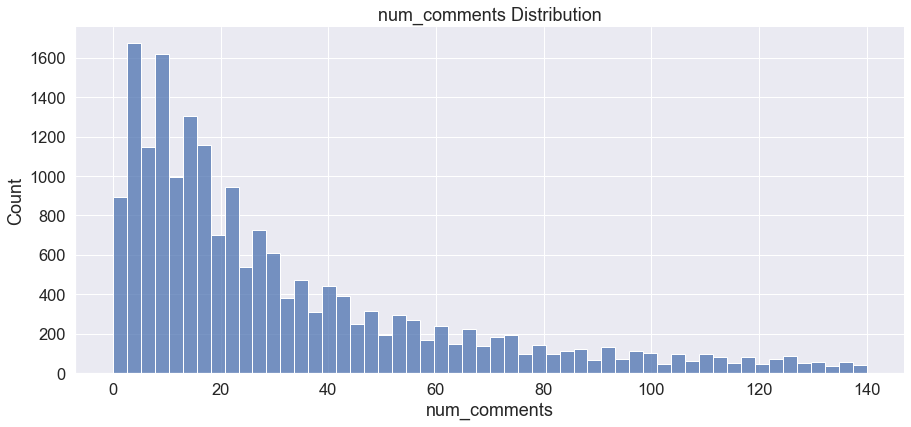

In [106]:
sns.set(font_scale=1.5)
# sns.set(rc={'figure.figsize':(15.7,8.27)})
# plt.figure(figsize=(15,10))

sns.displot(df_subs_3, x='num_comments', height=6, aspect= 13/6).set(title='num_comments Distribution')


;


''

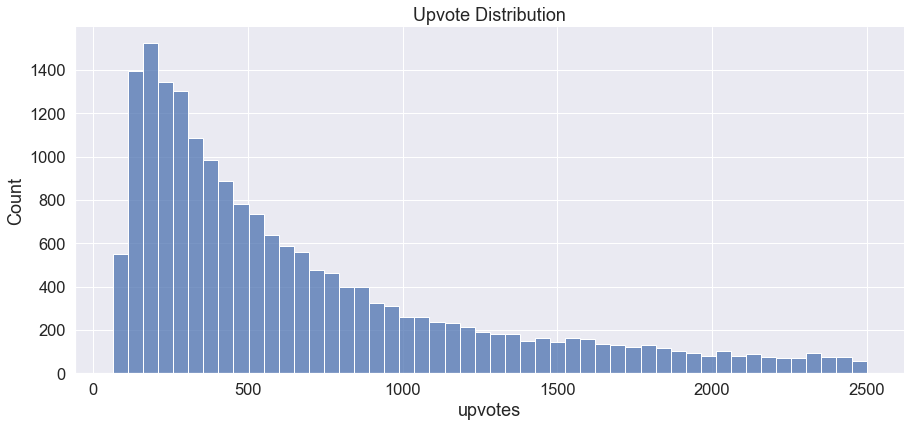

In [107]:

# sns.set(font_scale=1.4)
sns.displot(df_subs_3, x="upvotes", height=6, aspect= 13/6).set(title='Upvote Distribution')

;

### After dropping many rows with outlier num_comments and upvotes the dataset was applied to Random Forest again using our best parameters. We actually see a decrease in our overall scores

In [108]:
%%time
rf3 = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 400,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.02,
#                             oob_score=True,
                            min_samples_split=.1,
                            max_depth = 150,
                            random_state=620)



X_3 = df_subs_3.drop(['num_comments', 'titles', 'subreddits', 'target_y', 'age_post', 'upvotes','age_post_sec'], axis=1)
y_3 = df_subs_3['target_y']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,
                                                            y_3,
                                                            test_size = 0.20,
                                                            random_state = 620)

rf3.fit(X_train_3, y_train_3)
rf3.score(X_train_3, y_train_3)
rf3.score(X_test_3, y_test_3)
print(score(rf3, 'Random Forest 3', X_train_3, y_train_3))
print(score(rf3, 'Random Forest 3', X_test_3, y_test_3))
print(score(rf3, 'Random Forest 3', X_3, y_3))

Random Forest 3 Score: 0.70 +- 0.015
None
Random Forest 3 Score: 0.69 +- 0.035
None
Random Forest 3 Score: 0.70 +- 0.019
None
CPU times: user 14.9 s, sys: 451 ms, total: 15.3 s
Wall time: 43.9 s


### Plotting the ROC curve / AUC for our best model

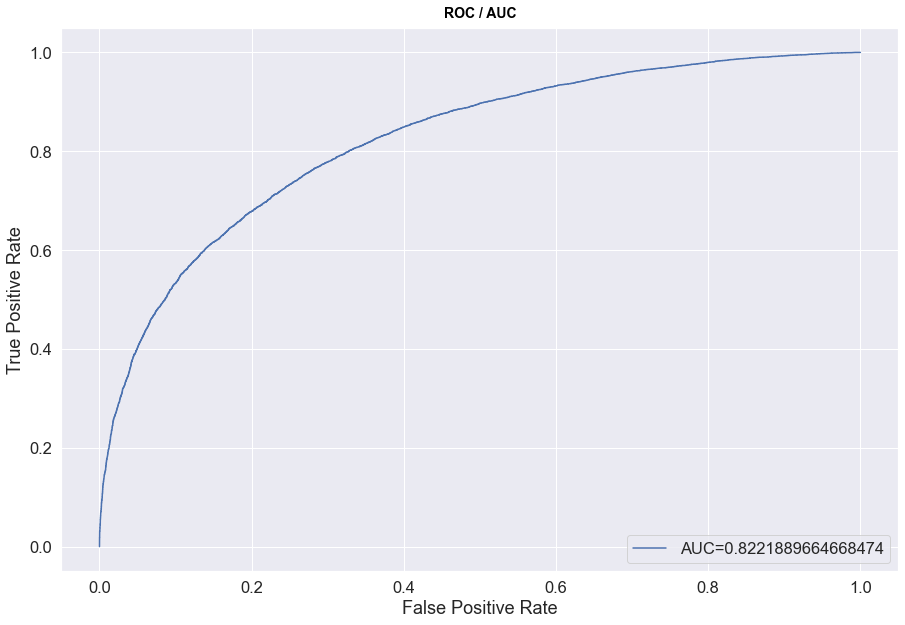

In [109]:
#define metrics
y_pred_proba = rf2.predict_proba(X_2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_2,  y_pred_proba)
auc = metrics.roc_auc_score(y_2, y_pred_proba)

#create ROC curve
plt.figure(figsize=(15,10))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC / AUC',
            fontdict=dict(fontsize=14,
            fontweight='bold',
            color='black'),
            pad=10)
plt.legend(loc='lower right')
plt.show()


### I am separating the top important features for the model by just words, and by subs, apart from the top 3 features

In [110]:
top_subs = feat_imp_subs[feat_imp_subs['Variable'].str.contains('sub_')]

In [111]:
top_words = feat_imp_subs[~feat_imp_subs["Variable"].str.contains('sub_')]

In [112]:
top_words = top_words.drop(top_words[(top_words['Variable'] == 'ups_ss')|\
                                     (top_words['Variable'] == 'time_sec_ss')|\
                                     (top_words['Variable'] == 'title_word_count')].index)

In [113]:
top_words.reset_index(inplace=True, drop=True)
top_subs.reset_index(inplace=True, drop=True)

In [114]:
top_words.head(15)

,Variable,Importance
0,game,0.006317
1,people,0.005554
2,art,0.005345
3,cat,0.003491
4,gun,0.002339
5,say,0.002070
6,kid,0.001990
7,fuck,0.001803
8,update,0.001759
9,need,0.001684


In [115]:
top_subs.head(15)

,Variable,Importance
0,sub_squaredcircle,0.005751
1,sub_politicalcompassmemes,0.004816
2,sub_politics,0.004369
3,sub_publicfreakout,0.003917
4,sub_nba,0.003703
5,sub_facepalm,0.002635
6,sub_tumblr,0.002334
7,sub_hololive,0.002106
8,sub_baseball,0.001999
9,sub_hockey,0.001900


### Showing the 25 features by importance in our Random Forest model

''

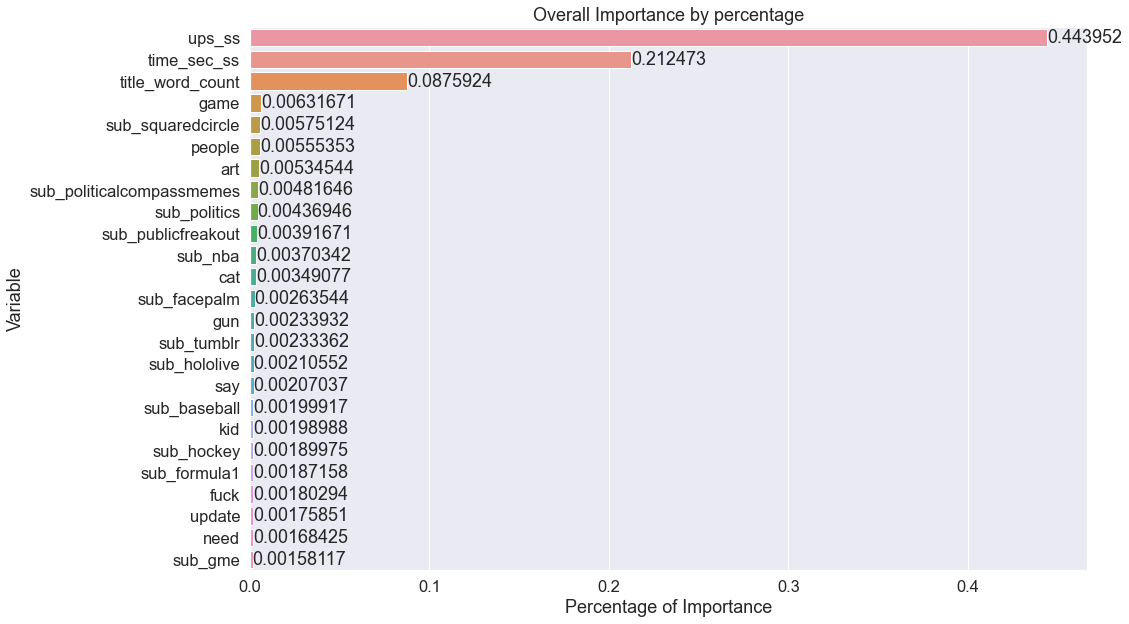

In [116]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Importance', y='Variable', data=feat_imp_subs[:25])
ax.set_xlabel('Percentage of Importance')
ax.set_title('Overall Importance by percentage')
for i in ax.containers:
    ax.bar_label(i)
;

''

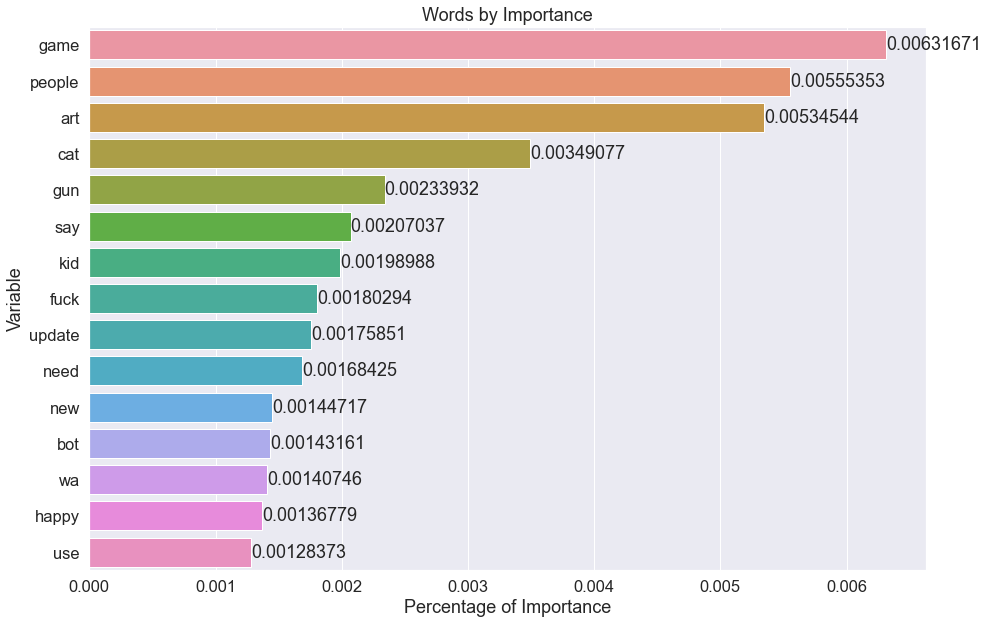

In [117]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Importance', y='Variable', data=top_words[:15])
ax.set_xlabel('Percentage of Importance')
ax.set_title('Words by Importance')
for i in ax.containers:
    ax.bar_label(i)
;

''

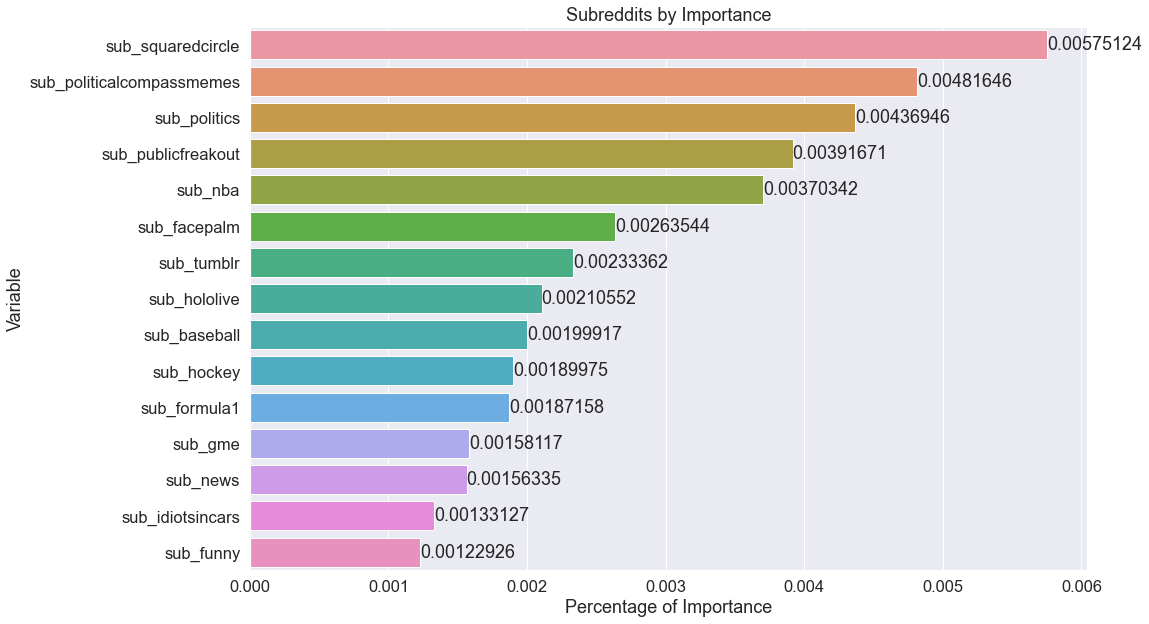

In [118]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Importance', y='Variable', data=top_subs[:15])
ax.set_xlabel('Percentage of Importance')
ax.set_title('Subreddits by Importance')
for i in ax.containers:
    ax.bar_label(i)
;

### Calculating and plotting the confusion matrix as well as metrics

In [119]:
preds = rf2.predict(X_2)

In [120]:
matrix = confusion_matrix(y_2, preds)

''

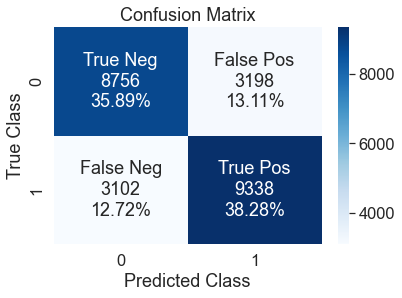

In [121]:

preds = rf2.predict(X_2)

matrix = confusion_matrix(y_2, preds)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')

;

In [122]:
TP = 9322
TN = 8787
FP = 3167
FN = 3118

Accuracy = (TN+TP)/(TN+FP+FN+TP)
Precision = TP/(FP+TP)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)

print(f'Accuracy: {round(Accuracy,4)}\n\
Precision: {round(Precision,4)}\n\
Sensitivity: {round(Sensitivity,4)}\n\
Specificity: {round(Specificity,4)}')
TP + TN + FP + FN

Accuracy: 0.7424
Precision: 0.7464
Sensitivity: 0.7494
Specificity: 0.7351


24394

In [123]:
from sklearn.metrics import classification_report

# support: num of observation in the labelled class
print(classification_report(y_2, preds))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74     11954
           1       0.74      0.75      0.75     12440

    accuracy                           0.74     24394
   macro avg       0.74      0.74      0.74     24394
weighted avg       0.74      0.74      0.74     24394



### Conclusions and Findings

 After getting the best scores while using the random forest model with our chosen parameters, we extracted which features were of greatest importance to the model itself. It has shown that far and above the amount of upvotes were important in predicting the target feature. Followed by title word count and our standard scaled time in seconds. From this we can deduce that given enough time as a /r/hot post and upvotes start to increase, so too will the number of comments on the post. 

 Furthermore, we have extracted the top words and subreddits that help our model predict the class with an accuracy of 74.24%. As previously shown above, we have the top 15 words and top 15 subreddits that are of importance to our predictive model.


#### Room for improvement:
 As in any research conducted there can always be room for improvement. If I were to be tasked with this objective again, or my contract is extended, I would like to do the following as well:

- More datapoints would be gathered per reddit post. Such as the type of post (video, picture, link, article, etc.) to see if this has any influence in user engagement.
- As well as taking the amount of time it has been on reddit I would get the posting date and time itself, so time of day, day of week, weekend/weekday can be analyzed as influential as well. 
- I would really like to also gather posts from /r/new as well. The posts that are in /r/hot are already deemed as "hot" by how many views, upvotes, comments, and shares they are gathering since time of posts. I want to see which posts that are posted to /r/new actually make it to hot, and which ones just fade into obscurity. I think this would really help differentiate the posts that will garnish more user engagement vs the ones that fizzle out and die. 
- Hire an assistant!

#### Citations

- Assistance with various problems was found with teachers Sophie Tabac and Lucas Courant.
- After hour TA's were of great assistance when stuck on a problem
- Most previous labs and notebooks
- Sci-kit learn website with their documentation.
- Googling things usually resulted in finding a solution on stack overflow
